In [1]:
###
# The goal of this notebook is to:
# - Look for categorization using traditional spike train measures

import glob
import os
from importlib import reload
import pickle
import datetime

import numpy as np
import scipy as sp
import pandas as pd
import h5py as h5
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import pycuslsa as pyslsa

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20190412/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075', 'B1083-5']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
      'B1083-5': '/home/brad/krista/B1083/P03S05/'}


learned_stimuli = {'B1083': ['M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung'], 'B1056': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 'B1235': [], 'B1075': []}
peck_stimuli = {'B1083': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}, 'B1056': {'L': ['B_scaled_burung', 'D_scaled_burung'], 'R': ['A_scaled_burung', 'C_scaled_burung']}, 
                'B1235': {'L': ['F_scaled_burung', 'H_scaled_burung'], 'R': ['E_scaled_burung', 'G_scaled_burung'],}, 'B1075': {'L': ['F_40k', 'H_40k'], 'R': ['E_40k', 'G_40k']},
               'B1083-5': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}}

unfamiliar_stimuli = {'B1083': ['I_40k', 'J_40k', 'K_40k', 'L_40k'], 'B1083-5': ['I_40k', 'J_40k', 'K_40k', 'L_40k']}
unfamiliar_stimuli = {'B1083': ['I_40k', 'J_40k', 'K_40k', 'L_40k'], 
                      'B1083-5': ['I_40k', 'J_40k', 'K_40k', 'L_40k'],
                      'B1235': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 
                      'B1075': ['A_40k', 'B_40k', 'C_40k', 'D_40k'], 
                      'B1056': ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
                     }

#bps =  {'B1056': '/home/AD/btheilma/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
#        'B1235': '/home/AD/btheilma/krista/B1235/P02S01/'}
#test_birds = ['B1075', 'B1083','B1056', 'B1235']
#test_birds = ['B1075', 'B1235']
#test_birds = ['B1056', 'B1235']
#test_birds =['B1056', 'B1083']
#test_birds = ['B1083-5']
test_birds = ['B1083', 'B1083-5', 'B1056', 'B1235']
# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.0*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'TRAD_SP_CMP'            # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

In [3]:
# Loop through each bird in our list and bin the data
for bird in test_birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-0.0_seg-0-0-TRAD_SP_CMP/20180717T234845Z-10.0-0.0.binned
/home/brad/krista/B1083/P03S05/binned_data/win-10.0_dtovr-0.0_seg-0-0-TRAD_SP_CMP/20180717T235910Z-10.0-0.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-0.0_seg-0-0-TRAD_SP_CMP/20190411T203005Z-10.0-0.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-0.0_seg-0-0-TRAD_SP_CMP/20190411T203020Z-10.0-0.0.binned


In [5]:
# extract left vs right stims
# extract population tensors for the populations of interest
# Do not sort the stims
fam_population_tensors = {}
stimuli = []

for bird in test_birds:
    pt = []
    stimuli = peck_stimuli[bird]['L'] + peck_stimuli[bird]['R']
    print(stimuli)
    bdf = bdfs[bird]
    #population_tensors[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        #stimuli = f.keys()
        print(list(f.keys()))
        for stim in stimuli:
            poptens = np.array(f[stim]['pop_tens'])
            pt.append([poptens, stim])
            
    fam_population_tensors[bird] = pt

['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['B_scaled_burung', 'D_scaled_burung', 'A_scaled_burung', 'C_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
['F_scaled_burung', 'H_scaled_burung', 'E_scaled_burung', 'G_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']


In [6]:
# extract unfamiliar
# extract population tensors for the populations of interest
# Do not sort the stims
unfam_population_tensors = {}
stimuli = []

for bird in test_birds:
    pt = []
    stimuli = unfamiliar_stimuli[bird]
    print(stimuli)
    bdf = bdfs[bird]
    #population_tensors[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        #stimuli = f.keys()
        print(list(f.keys()))
        for stim in stimuli:
            poptens = np.array(f[stim]['pop_tens'])
            pt.append([poptens, stim])
    unfam_population_tensors[bird] = pt

['I_40k', 'J_40k', 'K_40k', 'L_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']
['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']
['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']


In [7]:
pts = {'unfam': unfam_population_tensors, 'fam': fam_population_tensors}

In [8]:
# flatten the list of population tensors for each population
threshold = 6

def threshold_poptens(tens, thresh):
    ncell, nwins, ntrials = tens.shape
    frs = np.mean(tens, axis=1)
    tfr = thresh*frs
    tfrtens = np.tile(tfr[:, np.newaxis, :], (1, nwins, 1))
    bintens = 1*np.greater(tens, tfrtens)
    return bintens

def shuffle_binmat(binmat):
    ncells, nwin = binmat.shape
    for i in range(ncells):
        binmat[i, :] = np.random.permutation(binmat[i, :])
    return binmat

def filtered_response(spk_times, tau=1.):
    spk_times = spk_times.reshape((-1, 1))
    norm_factor = tau * np.sqrt(2. * np.pi)
    return lambda t: np.sum(np.exp(-(spk_times - t.reshape((1, -1))) ** 2 / (2 * tau * tau)), 0) / norm_factor

def gsmooth(mat, tau=1.):
    ncell, nwin = mat.shape
    retmat = np.zeros((ncell, nwin))
    sptms = [np.nonzero(t)[0] for t in mat]
    
    for c in range(ncell):
        fr = filtered_response(sptms[c], tau)
        frr = fr(np.arange(nwin))
        retmat[c, :] = frr
    return retmat

In [8]:
plt.plot(gsmooth(bin_tensor[:, :, 13]))

NameError: name 'bin_tensor' is not defined

In [9]:

cdata = {}
ntrials = 20

for o in ['orig', 'shuf']:
    fdata = {}
    for f in ['fam', 'unfam']:
        population_tensors = pts[f]
        binmatbirds = []
        for bird in test_birds:
            binmatlist = []
            bird_tensors = population_tensors[bird]
            for bird_tensor, stim in bird_tensors:
                ncells, nwin, _ = bird_tensor.shape
                bin_tensor = threshold_poptens(bird_tensor, threshold)
                for trial in tqdm(range(ntrials)):
                    if o == 'shuf':
                        mat = shuffle_binmat(bin_tensor[:, :, trial])
                    else:
                        mat = bin_tensor[:, :, trial]
                    binmatlist.append(gsmooth(mat, 1))
            binmatbirds.append(binmatlist)
        fdata[f] = binmatbirds
    cdata[o] = fdata

#     ntrials = 20 # Only do half the trials for each stim
#     binmatbirds_orig = []
#     for bird in test_birds:
#         binmatlist = []
#         bird_tensors = population_tensors[bird]
#         for bird_tensor, stim in bird_tensors:
#             ncells, nwin, _ = bird_tensor.shape
#             bin_tensor = threshold_poptens(bird_tensor, threshold)
#             for trial in tqdm(range(ntrials)):
#                 binmatlist.append(gsmooth(bin_tensor[:, :, trial]))

#         binmatbirds.append(binmatlist)

#     binmats[]

In [26]:
# Shuffled
ntrials = 20 # Only do half the trials for each stim
binmatbirds = []
for bird in test_birds:
    binmatlist = []
    bird_tensors = population_tensors[bird]
    for bird_tensor, stim in bird_tensors:
        ncells, nwin, _ = bird_tensor.shape
        bin_tensor = threshold_poptens(bird_tensor, threshold)
        for trial in tqdm(range(ntrials)):
            shuffmat = shuffle_binmat(bin_tensor[:, :, trial])
            binmatlist.append(gsmooth(shuffmat))
                
    binmatbirds.append(binmatlist)

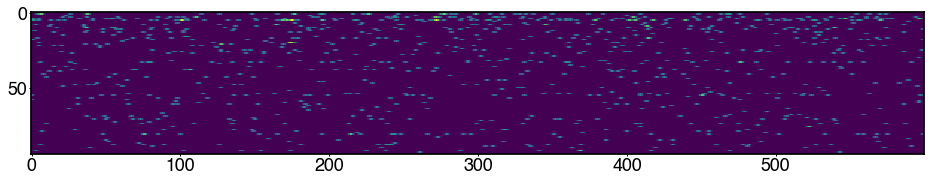

In [62]:
plt.figure(figsize=(16, 8))
plt.imshow(binmatlist[0])

In [10]:
# Compute JS popA:
#Left vs right

from numpy.linalg import norm
dmats = {}

fam = 'unfam'
shuff = 'shuf'

for o in ['orig', 'shuf']:
    fdata = {}
    for fa in ['fam', 'unfam']:
        binmatbirds = cdata[o][fa]  
        for pop, pop_bird in zip(binmatbirds, test_birds):
            print(test_birds)
            N = len(pop)
            dmat = np.zeros((N,N))
            for i in tqdm(range(N)):
                for j in tqdm(range(i, N)):
                    x = pop[i]
                    y = pop[j]
                    mx = np.mean(x)
                    my = np.mean(y)
                    numerator = np.sum(np.multiply(x-mx, y-my))
                    denom = np.sqrt(np.sum((x-mx)**2) * np.sum((y-my)**2))
                    dmat[i, j] = numerator/denom
            with open('/home/brad/tmpdata/new_Correl_{}_{}_{}.pkl'.format(pop_bird, fa, o), 'wb') as f:
                pickle.dump(1-dmat, f)
            dmats[(pop_bird, o, fa)] = 1- (dmat + dmat.T)

dsym = dmats[0] + dmats[0].T

['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']



['B1083', 'B1083-5', 'B1056', 'B1235']


KeyError: 0

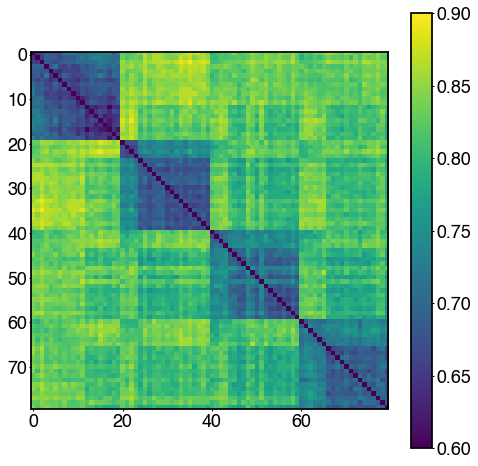

In [13]:
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
plt.figure(figsize=(8,8))
plt.imshow(dmats[('B1083', 'orig', 'fam')], vmin=0.6, vmax=.9)
plt.colorbar()
#plt.title('B1083 Population 1 - Correlations')

In [ ]:
# cond: -1 = different, 1 = same class
import seaborn as sns
def build_lmm_dataset(div_matrix):
    n, _ = np.shape(div_matrix)
    h = int(n/2)
    
    LR_mask = np.zeros((n, n))
    LR_mask[0:h, h:n] = 1
    LR_data = div_matrix[0:h, h:n]
    LR_inds = np.nonzero(LR_mask)
    LR_condition = len(LR_inds[0])*['different']
    LR_i = LR_inds[0]
    LR_j = LR_inds[1]
    
    LL_data = div_matrix[0:h, 0:h][np.triu_indices(20, 1)]
    LL_condition = len(LL_data)*['same']
    LL_i = np.triu_indices(20, 1)[0]
    LL_j = np.triu_indices(20, 1)[1]
    
    RR_data = div_matrix[h:n, h:n][np.triu_indices(20, 1)] 
    RR_condition = len(RR_data)*['same']
    RR_i = np.triu_indices(20, 1)[0] + h
    RR_j = np.triu_indices(20, 1)[1] + h
    
    dat_cat = np.concatenate((LL_data, LR_data.flatten(), RR_data))
    i_cat = np.concatenate((LL_i, LR_i, RR_i))
    j_cat = np.concatenate((LL_j, LR_j, RR_j))
    cond_cat = np.concatenate((LL_condition, LR_condition, RR_condition))
    
    df_out = pd.DataFrame(data={'JS': dat_cat, 'i': i_cat, 'j': j_cat, 'cond': cond_cat})
    return df_out

dataset = build_lmm_dataset(dsym)
dataset.to_csv(os.path.join(figsavepth, 'Correldataframe_pop1.csv'))
sns.barplot(x='cond', y='JS', data=dataset)

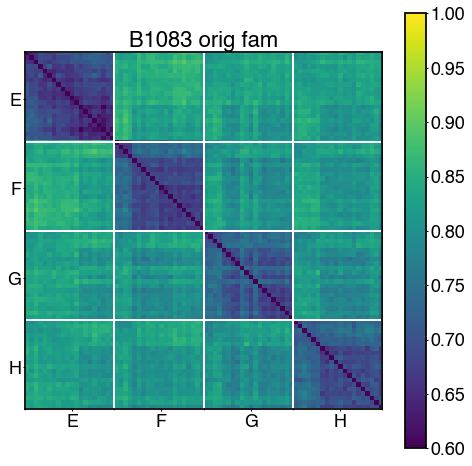

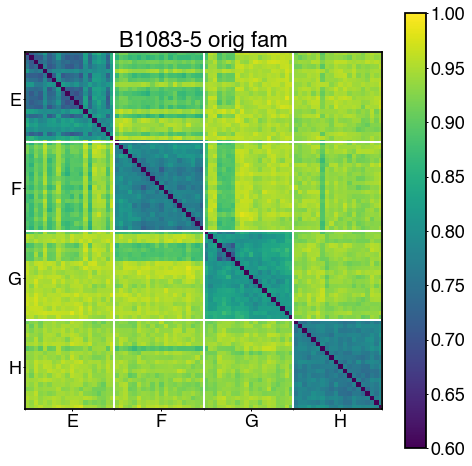

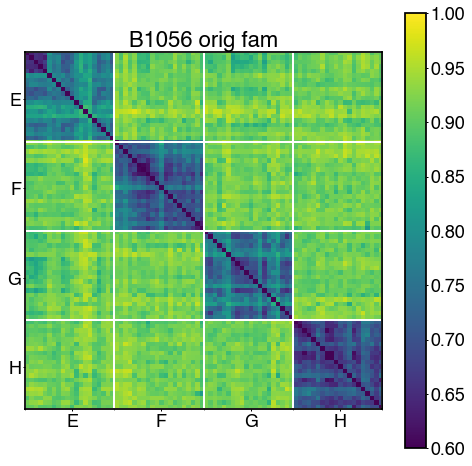

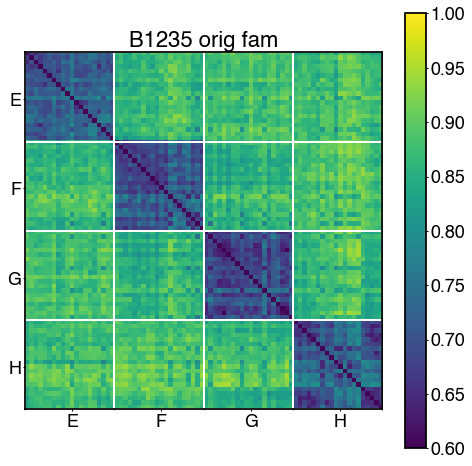

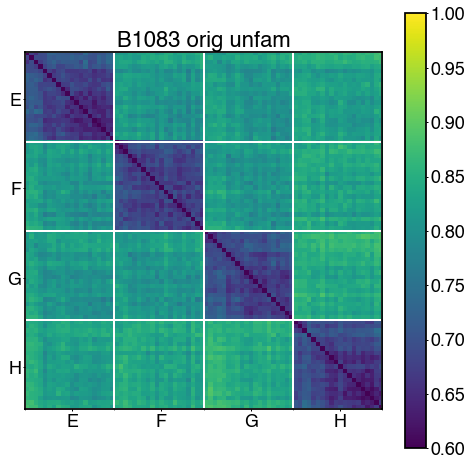

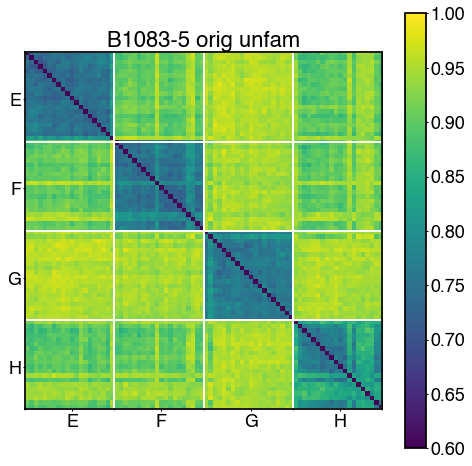

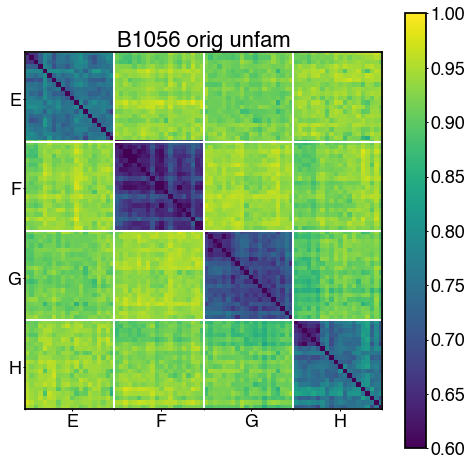

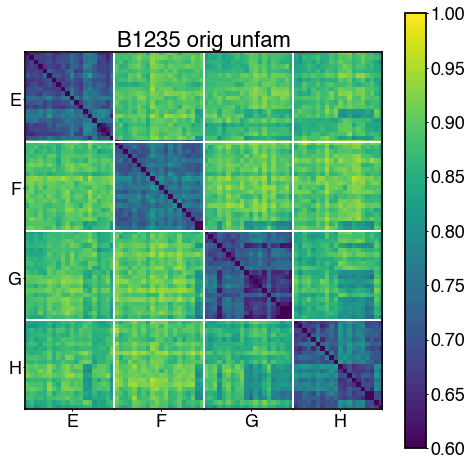

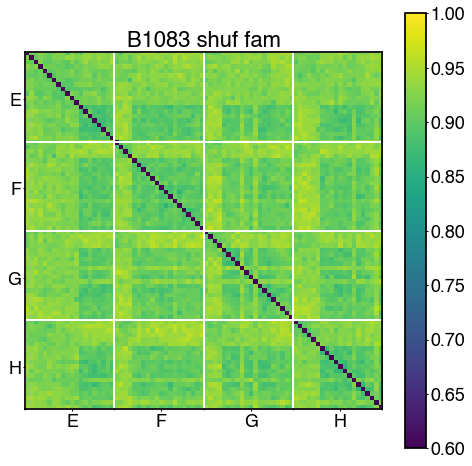

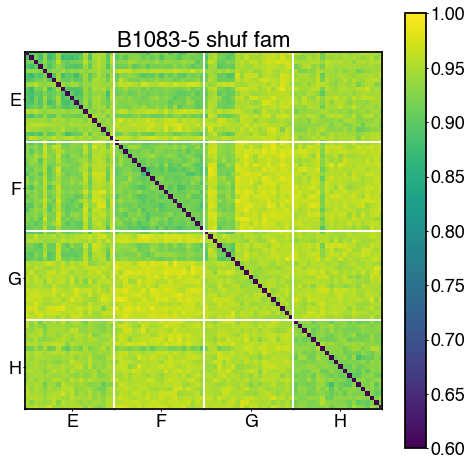

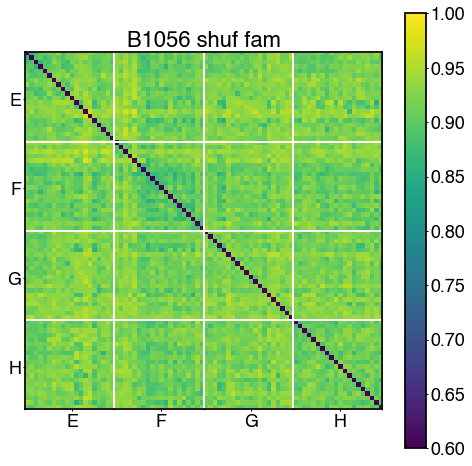

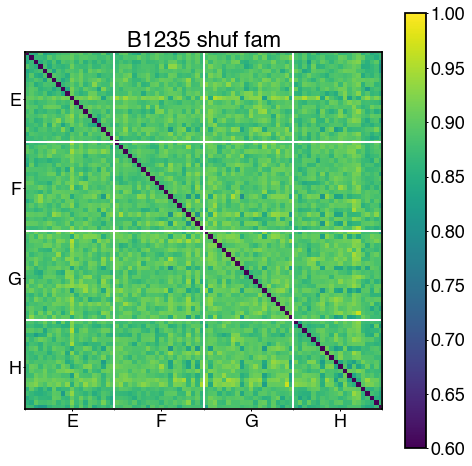

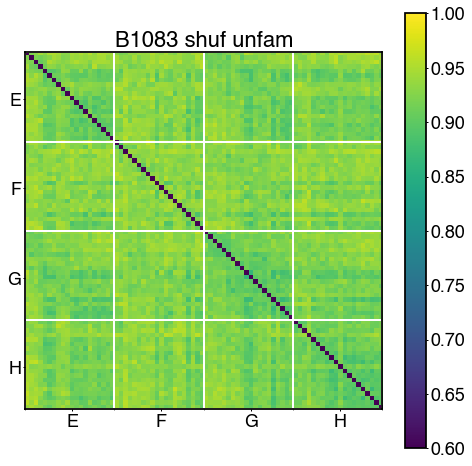

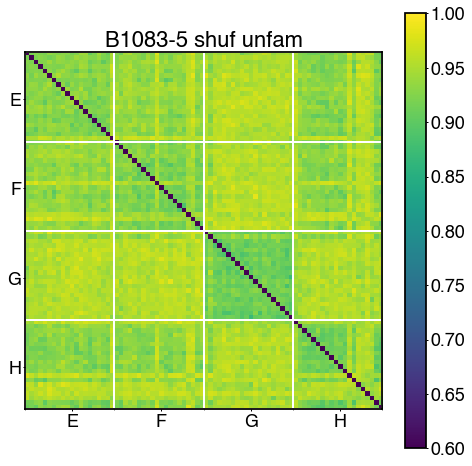

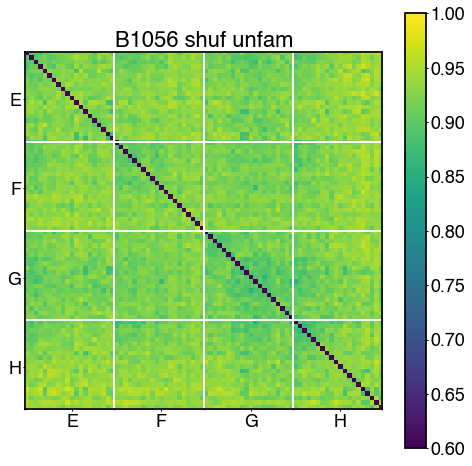

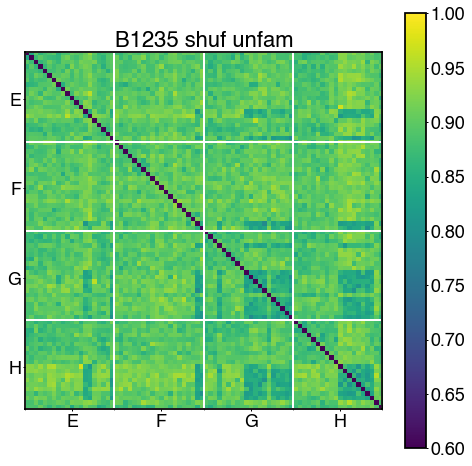

In [18]:
for k in dmats.keys():
    dmat = dmats[k]
    (bird, fam, shuf) = k
    ticklabels = [['A', 'B', 'C', 'D'], ['E', 'F', 'G', 'H']]
    tl = ticklabels[1]
    plt.figure(figsize=(8,8))
    ntrials = 20
    nstim = 4
    ax = plt.gca()
    plt.imshow(dmat, vmin=0.6, vmax=1.0, aspect='equal')
    #     plt.xticks(np.arange(0,ntrials*nstim, ntrials))
    #     plt.yticks(np.arange(0,ntrials*nstim, ntrials))
    ax.set_yticks(np.arange(-0.5, ntrials*nstim, ntrials), minor=True)
    ax.set_xticks(np.arange(-0.5, ntrials*nstim, ntrials), minor=True)
    ax.set_xticks(np.arange(10, 80, ntrials))
    ax.set_yticks(np.arange(10, 80, ntrials))

    ax.set_xticklabels(tl)
    ax.set_yticklabels(tl)
    ax.set_xlim([-0.5, 79.5])
    ax.set_ylim([79.5, -0.5])

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    plt.colorbar()
    plt.title('{} {} {}'.format(bird, fam, shuf))
    plt.savefig(os.path.join(figsavepth, '{}_{}_{}_correlations.pdf'.format(bird, fam, shuf)))